In [ ]:
# Question 1 (a)

In [ ]:
# import packages
import yfinance as yf
import numpy as np
from scipy.optimize import newton
from scipy.stats import norm

In [ ]:
# Determine the volatility
sp500 = yf.download('^SPX', start='2013-01-01',end='2023-12-31')['Close']
log_returns = np.log(sp500 / sp500.shift(1))
log_returns = log_returns.dropna()

sigma = np.std(log_returns.values)*np.sqrt(250)
print("\n")
print("The estimated annualized volatility for sp500 is", round(sigma,3))

[*********************100%%**********************]  1 of 1 completed



The estimated annualized volatility for sp500 is 0.172


In [ ]:
# Question 1 (b)

In [ ]:
r = 0.0409 # 3-year interest rate
T = 3
L = 200000
sigma = 0.172
g_set = [-0.01,-0.005,0,0.005,0.01,0.015,0.02]
G_set = []
S0 = sp500.values[-1]
n_shares = L/S0

def Bscall(St,K,T,sigma,r):
  d1 = (np.log(St/K) + (r + sigma**2/2)*T) / (sigma*np.sqrt(T))
  d2 = d1 - sigma * np.sqrt(T)
  return St*norm.cdf(d1) - K*np.exp(-r*T)*norm.cdf(d2),norm.cdf(d1)

def portfolio_price(St,g,G,L,T,sigma,r): # Use S0 here
  K1 = (1+g)**T*St
  K2 = (1+G)**T*St

  P1_call = Bscall(St,K1,T,sigma,r)[0]
  P2_call = Bscall(St,K2,T,sigma,r)[0]

  bond = L*np.exp(-r*T)*((1+g)**T)

  portfolio = bond + n_shares * (P1_call - P2_call)
  return portfolio-L

for i in range(len(g_set)):
  g = float(g_set[i])
  St = S0
  G_solution = newton(lambda G: portfolio_price(S0,g,G,L,T,sigma,r),0.1)
  G_set.append(round(G_solution,3))

print(g_set)
print(G_set)

[-0.01, -0.005, 0, 0.005, 0.01, 0.015, 0.02]
[0.108, 0.101, 0.095, 0.088, 0.082, 0.076, 0.069]


In [ ]:
# Question 1 (c)

In [ ]:
g = 0
r = 0.0016
L = 200000
sigma = 0.172
T = 3

sp500_new = yf.download('^SPX', start='2021-01-01',end='2023-12-31')['Close']

S0 = sp500_new[0]
n_shares_new = L/S0
St = S0

G_new = newton(lambda G: portfolio_price(St,g,G,L,T,sigma,r),0.1)

print("\n")
print("The solution for G is",round(G_new,4))

[*********************100%%**********************]  1 of 1 completed



The solution for G is 0.0047


In [ ]:
def delta_hedge(St,K1,K2,T,sigma,r,N):

  C0 = Bscall(S0,K1,T,sigma,r)[0] - Bscall(S0,K2,T,sigma,r)[0]
  D0 = N*(Bscall(S0,K1,T,sigma,r)[1] - Bscall(S0,K2,T,sigma,r)[1])
  Fund = [C0]
  Delta = [D0]
  Bank = [C0-D0*S0]
  gap = []

  for i in range(len(St)):
    Fund = np.append(Fund,Bank[i]*np.exp(r*dt)+Delta[i]*St[i])
    Delta = np.append(Delta,N*Bscall(St[i],K1,T-(i+1)*dt,sigma,r)[1]-N*Bscall(St[i],K2,T-(i+1)*dt,sigma,r)[1])
    Bank = np.append(Bank,Fund[i+1]-Delta[i+1]*St[i])
    gap = np.append(gap,float(Fund[i])-float(max(St[i]-K1,0))+float(max(St[i]-K2,0)))

  return float(Fund[-1])-float(max(St[-1]-K1,0))+float(max(St[-1]-K2,0)),gap

In [ ]:
import pandas as pd

sp500_new = pd.DataFrame(sp500_new)
St = sp500_new["Close"]
g = 0
G = 0.0047
T = 3
dt = T/len(sp500_new)
K1 = (1+g)**T*S0
K2 = (1+G)**T*S0
N = L/S0
sigma = 0.172
r = 0.0016

PL = delta_hedge(St,K1,K2,T,sigma,r,N)[0]
gap = delta_hedge(St,K1,K2,T,sigma,r,N)[1]
print(PL)

<ipython-input-218-1cb347e6038b>:11: RuntimeWarning: divide by zero encountered in scalar divide
  d1 = (np.log(St/K) + (r + sigma**2/2)*T) / (sigma*np.sqrt(T))


1424.5966917880794


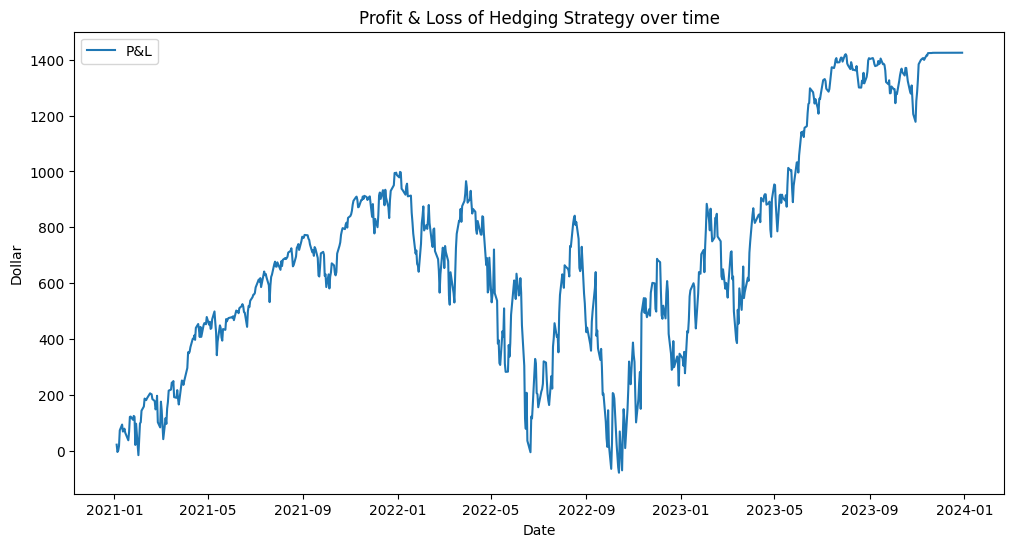

In [ ]:
import matplotlib.pyplot as plt  # Library to plot data

plt.figure(figsize=(12, 6))
plt.plot(sp500_new.index, gap, label='P&L')
plt.title("Profit & Loss of Hedging Strategy over time")  # Set the plot title
plt.xlabel('Date')  # X-axis label
plt.ylabel('Dollar')  # Y-axis label
plt.grid(True)  # Add gridlines
plt.legend()  # Display the legend
plt.grid(False)
plt.show()  # Show the plot


In [ ]:
# Question 2 (a)

In [ ]:
import numpy as np
from scipy.optimize import minimize

# Yield curve times (in years)
T = np.array([0.25, 0.5, 1, 2, 3, 5])
# Observed yields
y_obs = np.array([0.0546, 0.0524, 0.048, 0.0433, 0.0409, 0.0393])
# Current short rate
rt = 0.053

# Function for Vasicek model zero-coupon bond pricing
def P0_Vasicek(rt, t, T, alpha, beta, gamma):
    A_t_T = (1 - np.exp(-alpha * (T - t))) / alpha
    B_t_T = (beta - gamma ** 2 / (2 * alpha ** 2)) * (A_t_T - (T - t)) - (gamma ** 2 / (4 * alpha)) * A_t_T ** 2

    # This is the bond price, but for the yield curve, you need -log(p_t_T) / (T - t)
    p_t_T = np.exp(-A_t_T * rt + B_t_T)
    return p_t_T

# Function to calculate the yield from bond price
def yield_from_price(p_t_T, t, T):
    return -np.log(p_t_T) / (T - t)

# Objective function to minimize
def objective(params):
    alpha, beta, gamma = params
    t = 0
    predicted_yields = []

    for T_ in T:
        p_t_T = P0_Vasicek(rt, t, T_, alpha, beta, gamma)
        predicted_yield = yield_from_price(p_t_T, t, T_)
        predicted_yields.append(predicted_yield)

    # Calculate the squared error between observed and predicted yields
    squared_error = np.sum((np.array(predicted_yields) - y_obs) ** 2)
    return squared_error

# Initial guess for the parameters
initial_guess = [0.1, 0.05, 0.01]

# Bounds for the parameters (alpha, beta, gamma must be positive)
bounds = [(0.01, 1), (0.01, 1), (0.01, 1)]

result = minimize(objective, initial_guess, bounds=bounds, method='L-BFGS-B')
optimal_params = result.x

print("Optimal alpha, beta, gamma:", optimal_params)

Optimal alpha, beta, gamma: [0.511884   0.03041437 0.01002078]


In [ ]:
import numpy as np
from scipy.optimize import newton
import yfinance as yf
import pandas as pd
import pandas_datareader as pdr
from datetime import datetime

# Fetch data
treasury_symbol = "DGS3"
start_date = datetime(2013, 1, 1)
end_date = datetime(2023, 12, 31)
rt_series = pdr.get_data_fred(treasury_symbol, start=start_date, end=end_date).dropna()
st_series = yf.download('^SPX', start=start_date, end=end_date)[["Close"]].dropna()

df = rt_series.merge(st_series, how='inner', left_index=True, right_index=True)

df.columns = ['rt', 'st']

sigma = 0.172
alpha = 0.511884
beta = 0.03041437
gamma = 0.01002078
delta_t = 10/len(df)

def Xt(t):
  return ((df['rt'][t+1]-df['rt'][t])-alpha*(beta-df['rt'][t]*delta_t))/gamma/np.sqrt(delta_t)

def avgXt():
  Xarr = [Xt(t) for t in range(len(df)-1)]
  return np.mean(Xarr)

def Yt(t,mu):
  return ((df['st'][t+1]-df['st'][t])/df['rt'][t]-mu*delta_t)/sigma/np.sqrt(delta_t)

def avgYt(mu):
  Yarr = [Yt(t,mu) for t in range(len(df)-1)]
  return np.mean(Yarr)

mu_hat = newton(lambda mu: avgYt(mu),1)
mu_hat

[*********************100%%**********************]  1 of 1 completed


998.483699003566

In [ ]:
Xt_arr = [Xt(t) for t in range(len(df)-1)]
# plug mu_hat into Yt and get a list of Yt
Yt_arr = [Yt(t,mu_hat) for t in range(len(df)-1)]

# remaining parameter to estimate: rho
# calcuate the correlation between Xt and Yt
rho_hat = np.corrcoef(Xt_arr,Yt_arr)[0,1]
rho_hat

0.07508183427289825

In [ ]:
sp_500 = yf.download('^SPX', start='2013-01-01',end='2023-12-31')['Close']
sp_500 = pd.DataFrame(sp_500)
S0 = sp_500["Close"][-1]
L = 200000
sigma = 0.172
alpha = 0.511884
beta = 0.03041437
gamma = 0.01002078
rho_hat = 0.07508183427289825
n_shares = L/S0
g_set = [-0.01,-0.005,0,0.005,0.01,0.015,0.02]
G_set = []
t = 0
T = 3
rt = 0.0409

def P0_Vasicek(rt, t, T, alpha, beta, gamma):
    A_t_T = (1 - np.exp(-alpha * (T - t))) / alpha
    B_t_T = (beta - gamma ** 2 / (2 * alpha ** 2)) * (A_t_T - (T - t)) - (gamma ** 2 / (4 * alpha)) * A_t_T ** 2

    # This is the bond price, but for the yield curve, you need -log(p_t_T) / (T - t)
    p_t_T = np.exp(-A_t_T * rt + B_t_T)
    return p_t_T

def rt_delta_option(St,K,rt, t, T, alpha, beta, gamma, sigma,rho_hat):
  A_t_T = (1 - np.exp(-alpha * (T - t))) / alpha
  B_t_T = (beta - gamma ** 2 / (2 * alpha ** 2)) * (A_t_T - (T - t)) - (gamma ** 2 / (4 * alpha)) * A_t_T ** 2

  G_t_T = gamma/alpha/np.sqrt((T-t)-A_t_T-alpha/2*A_t_T**2)
  C_t_T = beta*(T-t) + (rt-beta)*A_t_T
  vega_2 = sigma**2 +G_t_T**2-2*rho_hat*sigma*G_t_T

  d1 = (np.log(St/K) + C_t_T - vega_2*(T-t)/2)/sigma/np.sqrt(T-t)+np.sqrt(vega_2)*np.sqrt(T-t)
  d2 = (np.log(St/K) + C_t_T - vega_2*(T-t)/2)/sigma/np.sqrt(T-t)-G_t_T*np.sqrt(T-t)

  V = St*norm.cdf(d1)-K*np.exp(-A_t_T * rt + B_t_T)*norm.cdf(d2)
  return V,norm.cdf(d1),-K*norm.cdf(d2)

def portfolio_price(St,g,G,L,T,sigma,rt): # Use S0 here
  K1 = (1+g)**T*S0
  K2 = (1+G)**T*S0

  P1_call = rt_delta_option(St,K1,rt, t, T, alpha, beta, gamma, sigma,rho_hat)[0]
  P2_call = rt_delta_option(St,K2,rt, t, T, alpha, beta, gamma, sigma,rho_hat)[0]

  bond = L*((1+g)**T)*P0_Vasicek(rt, t, T, alpha, beta, gamma)

  portfolio = bond + n_shares * (P1_call - P2_call)

  return portfolio-L

for i in range(len(g_set)):
  g = float(g_set[i])
  St = S0
  G_solution = newton(lambda G: portfolio_price(S0,g,G,L,T,sigma,r),0.1)
  G_set.append(round(G_solution,3))

print(g_set)
print(G_set)

[*********************100%%**********************]  1 of 1 completed

[-0.01, -0.005, 0, 0.005, 0.01, 0.015, 0.02]
[0.049, 0.043, 0.036, 0.03, 0.023, 0.017, 0.01]


In [ ]:
mean = [(g_set[i]+G_set[i])/2 for i in range(len(g_set))]
mean

[0.0195, 0.019, 0.018, 0.017499999999999998, 0.0165, 0.016, 0.015]

In [ ]:
# Question2(c)

In [ ]:
def new_delta_hedge(St,K1,K2,T,sigma,rt,N):

  C0 = rt_delta_option(S0,K1,rt[0], 0, T, alpha, beta, gamma, sigma,rho_hat)[0] - rt_delta_option(S0,K2,rt[0], 0, T, alpha, beta, gamma, sigma,rho_hat)[0]
  D0 = N*(rt_delta_option(S0,K1,rt[0], 0, T, alpha, beta, gamma, sigma,rho_hat)[1] - rt_delta_option(S0,K2,rt[0], 0, T, alpha, beta, gamma, sigma,rho_hat)[1])
  B0 = rt_delta_option(S0,K1,rt[0], 0, T, alpha, beta, gamma, sigma,rho_hat)[2] - rt_delta_option(S0,K2,rt[0], 0, T, alpha, beta, gamma, sigma,rho_hat)[2]
  Fund = [C0]
  Delta = [D0]
  Bond = [B0]
  Bank = [C0-D0*S0-B0]
  gap = []

  for i in range(len(St)):
    Fund = np.append(Fund,Bank[i]*np.exp(rt[i]*dt)+Delta[i]*St[i]+Bond[i]*np.exp(rt[i]*dt))
    Delta = np.append(Delta,N*rt_delta_option(St,K1,rt[i], (i+1)*dt, T, alpha, beta, gamma, sigma,rho_hat)[1]-N*rt_delta_option(St,K2,rt[i], (i+1)*dt, T, alpha, beta, gamma, sigma,rho_hat)[1])
    Bond = np.append(Bond,rt_delta_option(St,K2,rt[i], (i+1)*dt, T, alpha, beta, gamma, sigma,rho_hat)[2]-rt_delta_option(St,K2,rt[i], (i+1)*dt, T, alpha, beta, gamma, sigma,rho_hat)[2])
    Bank = np.append(Bank,Fund[i+1]-Delta[i+1]*St[i])

    gap = float(Fund[i])-float(max(St[i]-K1,0))+float(max(St[i]-K2,0))
  return float(Fund[-1])-float(max(St[-1]-K1,0))+float(max(St[-1]-K2,0)),gap

In [ ]:
import pandas as pd
import pandas_datareader as pdr
from datetime import datetime

SP500 = yf.download('^SPX', start='2021-01-01',end='2023-12-31')['Close']
SP500 = pd.DataFrame(SP500)

treasury_symbol = "DGS3"
start_date = datetime(2021, 1, 1)
end_date = datetime(2023, 12, 31)
rt = pdr.get_data_fred(treasury_symbol, start=start_date, end=end_date).dropna()/100

DF = rt.merge(SP500, how='inner', left_index=True, right_index=True)

S0 = DF["Close"][0]
St = DF["Close"]
rt = DF["DGS3"]

g = 0
G = 0.036
T = 3
dt = T/len(SP500)
L = 200000
sigma = 0.172
alpha = 0.511884
beta = 0.03041437
gamma = 0.01002078
rho_hat = 0.07508183427289825
K1 = (1+g)**T*S0
K2 = (1+G)**T*S0
N = L/S0

PL = new_delta_hedge(St,K1,K2,T,sigma,rt,N)[1]
print(PL)

[*********************100%%**********************]  1 of 1 completed


6786.249984302407


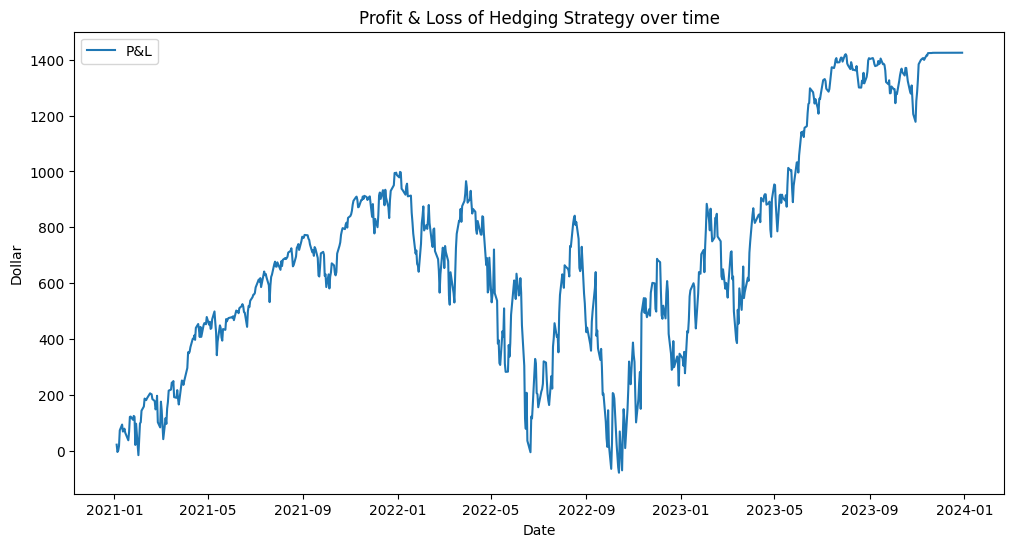

In [ ]:
import matplotlib.pyplot as plt  # Library to plot data

plt.figure(figsize=(12, 6))
plt.plot(SP500.index, gap, label='P&L')
plt.title("Profit & Loss of Hedging Strategy over time")  # Set the plot title
plt.xlabel('Date')  # X-axis label
plt.ylabel('Dollar')  # Y-axis label
plt.grid(True)  # Add gridlines
plt.legend()  # Display the legend
plt.grid(False)
plt.show()  # Show the plot


In [ ]:
# Question 3(a)(b)(c)

In [ ]:
import pandas as pd
import numpy as np
from datetime import datetime
from math import sqrt, exp
import QuantLib as ql

In [ ]:
def P0_Vasicek(rt, t, T, alpha, beta, gamma):
    A_t_T = (1 - np.exp(-alpha * (T - t))) / alpha
    B_t_T = (beta - gamma ** 2 / (2 * alpha ** 2)) * (A_t_T - (T - t)) - (gamma ** 2 / (4 * alpha)) * A_t_T ** 2

    p_t_T = np.exp(-A_t_T * rt + B_t_T)
    return p_t_T

In [ ]:
def vol_option_v(S_0,strike,v_0,volvol,rho,r,dividend,today,day_count,maturity):
  initial_value = ql.QuoteHandle(ql.SimpleQuote(S_0))
  discount_curve = ql.YieldTermStructureHandle(ql.FlatForward(today,r,day_count))
  dividend_yield = ql.YieldTermStructureHandle(ql.FlatForward(today,dividend,day_count))
  heston_process = ql.HestonProcess(discount_curve,dividend_yield,initial_value,v_0,kappa,theta,volvol,rho)
  call_payoff = ql.PlainVanillaPayoff(ql.Option.Call, strike)
  call_exercise = ql.EuropeanExercise(maturity)
  option = ql.VanillaOption(call_payoff, call_exercise)
  engine = ql.AnalyticHestonEngine(ql.HestonModel(heston_process),0.001,1000)
  option.setPricingEngine(engine)
  price = option.NPV()

  return price

In [ ]:
sp500 = yf.download('^SPX', start='2013-01-01',end='2023-12-31')['Close'].values
vix = yf.download('^VIX', start='2013-01-01',end='2023-12-31')['Close'].values/100

L = 200000
S_0 = sp500[-1]
v_0 = vix[-1]**2
volvol = 0.172
rho = -0.4644
r = 0.0409
dividend = 0
t = 0
T = 3
n_shares = L/S0

alpha = 0.511884
beta = 0.03041437
gamma = 0.01002078



today = ql.Date(1,1,2024)
day_count = ql.Actual365Fixed()
maturity = ql.Date(31,12,2026)

g_set = [-0.01,-0.005,0,0.005,0.01,0.015,0.02]
G_set = []

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


In [ ]:
def vol_portfolio_price(S_0,v_0,volvol,rho,r,dividend):
  K1 = L*(1+g)**T
  K2 = L*(1+g)**T

  P1_call = vol_option_v(L,S_0,K1,v_0,volvol,rho,r,dividend,today,day_count,maturity)
  P2_call = vol_option_v(L,S_0,K2,v_0,volvol,rho,r,dividend,today,day_count,maturity)

  bond = L*((1+g)**T)*P0_Vasicek(rt, t, T, alpha, beta, gamma)

  portfolio = bond + n_shares * (P1_call - P2_call)
  return portfolio-L

for i in range(len(g_set)):
  g = float(g_set[i])
  St = S0
  G_solution = newton(lambda G: portfolio_price(S0,g,G,L,T,sigma,r),0.1)
  G_set.append(round(G_solution,3))

print(g_set)
print(G_set)

[-0.01, -0.005, 0, 0.005, 0.01, 0.015, 0.02]
[0.097, 0.09, 0.084, 0.077, 0.071, 0.064, 0.058]


In [ ]:
mean = [round((g_set[i]+G_set[i])/2,4) for i in range(len(g_set))]
mean

[0.0435, 0.0425, 0.042, 0.041, 0.0405, 0.0395, 0.039]